## This script analyzes the cleaned labeled data, remove outliars, and split them into the training, validation, and test sets, and then create tokenizers using TensorFlow.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import io
import json
import tensorflow as tf

# Loading the training data

SOURCE_TRANING_DATA_FILE             = "training_data/alpha_to_kana_cleaned.txt"
OUTPUT_TRANING_DATA_FILE_90_10_10    = "training_data/alpha_to_kana_train.txt"
OUTPUT_VALIDATION_DATA_FILE_90_10_10 = "training_data/alpha_to_kana_validation.txt"
OUTPUT_TEST_DATA_FILE_90_10_10       = "training_data/alpha_to_kana_test.txt"
TOKENIZER_ALPHAS                     = "training_data/alphas_tokenizer.json"
TOKENIZER_KANAS                      = "training_data/kanas_tokenizer.json"

In [7]:
kanas = []
alphas = []
with open(SOURCE_TRANING_DATA_FILE, "r", encoding="utf-8") as fp:
    for line in fp:
        alpha, kana = line.strip().split('\t')
        kanas.append(kana)
        alphas.append(alpha)

## Check the distribution of the lenghs

In [8]:
kanas_len = [len(s) for s in kanas]
alphas_len = [len(s) for s in alphas]

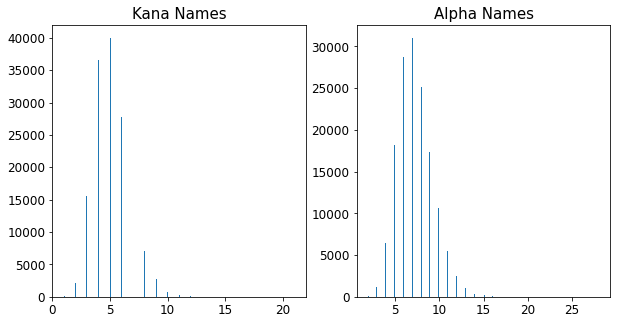

In [9]:
# Histograms

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(kanas_len, bins='auto')
plt.title("Kana Names", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.subplot(1,2,2)
plt.hist(alphas_len, bins='auto')
plt.title("Alpha Names", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('figs/hist_lens.png')

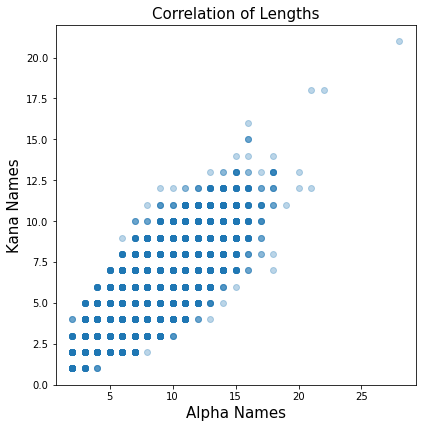

In [10]:
# Correlation

fig = plt.figure(figsize=(5,5))
ax=fig.add_axes([0.0,0.0,1.0,1.0])
ax.scatter(alphas_len, kanas_len, alpha=0.3)
ax.set_xlabel('Alpha Names', fontsize=15)
ax.set_ylabel('Kana Names', fontsize=15)
ax.set_title("Correlation of Lengths", fontsize=15)
plt.savefig('figs/data_corr.png', bbox_inches = "tight")

## Based on the observations above we cut off at length 16 for alphabets and 12 for kanas.

In [11]:
MAX_LEN_KANAS_CUTOFF  = 12
MAX_LEN_ALPHAS_CUTOFF = 16

zipped = zip(alphas, kanas)
cut_off = [(a, k) for a, k in zipped if len(a) <= MAX_LEN_ALPHAS_CUTOFF  and len(k) <= MAX_LEN_KANAS_CUTOFF]
random.shuffle(cut_off)
size_train      = int( len(cut_off) * 0.8 )
size_validation = int( len(cut_off) * 0.1 )
size_test       = int( len(cut_off) * 0.1 )
print(f'Training Set:[{size_train}], Validation Set:[{size_validation}], Test Set:[{size_test}]')

Training Set:[118642], Validation Set:[14830], Test Set:[14830]


In [12]:
with open( OUTPUT_TRANING_DATA_FILE_90_10_10, "w", encoding="utf-8" ) as fp:
    for item in cut_off[ : size_train ]:
        fp.write( item[0] + '\t' + item[1] + '\n' )
        
with open( OUTPUT_VALIDATION_DATA_FILE_90_10_10, "w", encoding="utf-8" ) as fp:
    for item in cut_off[ size_train : size_train + size_validation ]:
        fp.write( item[0] + '\t' + item[1] + '\n' )

with open( OUTPUT_TEST_DATA_FILE_90_10_10, "w", encoding="utf-8" ) as fp:
    for item in cut_off[ size_train + size_validation : ]:
        fp.write( item[0] + '\t' + item[1] + '\n' )

## Generate tokenizers and save them into JSON.
Adding two more tokens to each of the tokenizer. "<" for BOS, and ">" for EOS.

In [13]:
kanas_spaced = []
for kana_str in kanas:
    kana_list = []
    kana_list[:0] = kana_str
    kanas_spaced.append( "< " + ' '.join(kana_list) + " >" ) 

alphas_spaced = []
for alpha_str in alphas:
    alpha_list = []
    alpha_list[:0] = alpha_str
    alphas_spaced.append( "< " + ' '.join(alpha_list) + " >" ) 
    
alphas_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
alphas_tokenizer.fit_on_texts(alphas_spaced)    

kanas_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
kanas_tokenizer.fit_on_texts(kanas_spaced)    

alphas_json = alphas_tokenizer.to_json()
kanas_json = kanas_tokenizer.to_json()

with io.open(TOKENIZER_ALPHAS, 'w', encoding='utf-8') as f:
    f.write(json.dumps(alphas_json, ensure_ascii=False))

with io.open(TOKENIZER_KANAS, 'w', encoding='utf-8') as f:
    f.write(json.dumps(kanas_json, ensure_ascii=False))